### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [2]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Cleaned1.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
       'Del_n', 'Cuc','Cus','Toe', 'Cic', 'omega',
       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,e,OMEGA,i0
Epoch_Time_of_Clock,,,
2017-11-01 14:00:00,0.00709403527435000045,1.00937285970000001356,0.96871190895600001181
2017-11-01 16:00:00,0.00709456193727000042,1.00931255967999988776,0.96871347574200006303
2017-11-01 18:00:00,0.00709454016760000059,1.00925244690999993402,0.96871571254299992937
2017-11-01 20:00:00,0.00709462445228999962,1.00919191575000000149,0.96871721203500005259
2017-11-01 22:00:00,0.00709612155333000025,1.00913133191999992988,0.96871909334700001537


In [4]:
var_name = 'OMEGA'
sat_var = 1

In [5]:

df = df.iloc[5 : , :]

In [6]:

df.head(7)

,e,OMEGA,i0
Epoch_Time_of_Clock,,,
2017-11-02 12:00:00,0.00709870201535999987,1.00870849592999989319,0.96873138917400003489
2017-11-02 14:00:00,0.00709954684135000007,1.00864845192999985635,0.96873510791099992634
2017-11-02 16:00:00,0.00709992146584999956,1.00858859223999997035,0.96873808348699996795
2017-11-02 18:00:00,0.00710008526221000014,1.00852901782999992975,0.96874178466900007223
2017-11-02 20:00:00,0.00710032973439000091,1.00846886117999989807,0.96874462858199994475
2017-11-02 22:00:00,0.00710155733395000013,1.00840879082999990146,0.96874790990700010429
2017-11-03 12:00:00,0.00710492231883000022,1.00799067275000009403,0.96876999411899999970


In [9]:
df.columns

Index(['e', 'OMEGA', 'i0'], dtype='object')

# Enter number of entries per day

In [7]:
entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))

168
2017-11-25 12:00:00 2017-11-21 12:00:00
<class 'str'>



Load data into Pandas dataframe

# enter lag and no. of outputs

In [8]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 6
HORIZON = 6

Create training set containing only the model features

In [95]:
train = df.copy()[df.index < valid_start_dt][['e', 'OMEGA', 'i0' ]]
train.head()

,OMEGA
Epoch_Time_of_Clock,
2017-11-02 12:00:00,1.00870849592999989319
2017-11-02 14:00:00,1.00864845192999985635
2017-11-02 16:00:00,1.00858859223999997035
2017-11-02 18:00:00,1.00852901782999992975
2017-11-02 20:00:00,1.00846886117999989807


In [96]:
train.tail(6)

,OMEGA
Epoch_Time_of_Clock,
2017-11-20 12:00:00,0.63499334812499996783
2017-11-20 14:00:00,0.63493855599100001985
2017-11-20 16:00:00,0.63488355319700007229
2017-11-20 18:00:00,0.63482873911899995178
2017-11-20 20:00:00,0.63477265961800000138
2017-11-20 22:00:00,0.63471711993299995136


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [97]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[['e', 'OMEGA', 'i0']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [98]:
tensor_structure = {'X':(range(-T+1, 1), ['e', 'OMEGA', 'i0'])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), ['e', 'OMEGA', 'i0'])} ,freq = None)

In [99]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 22:00:00  1.61808765196250115004  1.61754653035883078083   
2017-11-03 12:00:00  1.61754653035883078083  1.61700740369882267622   
2017-11-03 14:00:00  1.61700740369882267622  1.61647116932270606959   
2017-11-03 16:00:00  1.61647116932270606959  1.61592889611410139850   
2017-11-03 18:00:00  1.61592889611410139850  1.61538859121451916501   
2017-11-03 20:00:00  1.61538859121451916501  1.61163470931397379005   
2017-11-03 22:00:00  1.61163470931397379005  1.61110484848813784176   
2017-11-04 12:00:00  1.61110484848813784176  1.61057712996599766697   
2017-11-04 14:00:00  1.61057712996599766697  1.61005214300463062038   
2017-11-04 16:00:00  1.61005214300463062038  1.60952111721077728568   
2017-11-04 18:00:00  1.60952111721077728568  1.60899302379006448049   
2017-11-04 20:00:00  1.60899302379006448049  0.50318622687538083760   
2017-11-04 22:00:00  0.50318622687538083760  0.50266746615002333431   
2017-11-05 12:00:00  0.50266746615002333431  0.50215059338128265054   
2017-11-05 14:00:00  0.50215059338128265054  0.50163637179345244022   
2017-11-05 16:00:00  0.50163637179345244022  0.50111603106649127426   
2017-11-05 18:00:00  0.50111603106649127426  0.50059917169744694299   
2017-11-05 20:00:00  0.50059917169744694299  0.49699706313551883508   
2017-11-05 22:00:00  0.49699706313551883508  0.49648617560963975714   
2017-11-06 12:00:00  0.49648617560963975714  0.49597637265360822179   
2017-11-06 14:00:00  0.49597637265360822179  0.49546970291054909241   
2017-11-06 16:00:00  0.49546970291054909241  0.49495574911525747064   
2017-11-06 18:00:00  0.49495574911525747064  0.49444550429879202680   
2017-11-06 20:00:00  0.49444550429879202680  0.49087480819152135014   
2017-11-06 22:00:00  0.49087480819152135014  0.49036662539956998863   
2017-11-07 12:00:00  0.49036662539956998863  0.48985817481507704096   
2017-11-07 14:00:00  0.48985817481507704096  0.48935398217587849912   
2017-11-07 16:00:00  0.48935398217587849912  0.48884001499919776945   
2017-11-07 18:00:00  0.48884001499919776945  0.48832981034520578367   
2017-11-07 20:00:00  0.48832981034520578367  0.48474555037837363525   
...                                     ...                     ...   
2017-11-15 12:00:00 -0.66297737572973403086 -0.66351639521048810799   
2017-11-15 14:00:00 -0.66351639521048810799 -0.66404975081223938105   
2017-11-15 16:00:00 -0.66404975081223938105 -0.66459178300023724617   
2017-11-15 18:00:00 -0.66459178300023724617 -0.66512840570207776292   
2017-11-15 20:00:00 -0.66512840570207776292 -0.66887997113035013719   
2017-11-15 22:00:00 -0.66887997113035013719 -0.66940629709101928668   
2017-11-16 12:00:00 -0.66940629709101928668 -0.66993701490240276097   
2017-11-16 14:00:00 -0.66993701490240276097 -0.67046312662355056489   
2017-11-16 16:00:00 -0.67046312662355056489 -0.67099751323298362227   
2017-11-16 18:00:00 -0.67099751323298362227 -0.67152686529143834626   
2017-11-16 20:00:00 -0.67152686529143834626 -0.67522284968184875797   
2017-11-16 22:00:00 -0.67522284968184875797 -0.67574128905249997157   
2017-11-17 12:00:00 -0.67574128905249997157 -0.67626286163611948332   
2017-11-17 14:00:00 -0.67626286163611948332 -0.67678084575579311455   
2017-11-17 16:00:00 -0.67678084575579311455 -0.67730756002388103898   
2017-11-17 18:00:00 -0.67730756002388103898 -0.67783107412628607058   
2017-11-17 20:00:00 -0.67783107412628607058 -0.68147112935219744667   
2017-11-17 22:00:00 -0.68147112935219744667 -0.68198203026861814458   
2017-11-18 12:00:00 -0.68198203026861814458 -0.68249518067714354252   
2017-11-18 14:00:00 -0.68249518067714354252 -0.68300562634258765726   
2017-11-18 16:00:00 -0.68300562634258765726 -0.68352445402065553637   
2017-11-18 18:00:00 -0.6

In [100]:
train_inputs['target'].shape

(103, 6)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [101]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][['e', 'OMEGA', 'i0']]
valid[['e', 'OMEGA', 'i0']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.80805118497488681584 -1.80855488218232896003   
2017-11-22 12:00:00 -1.80855488218232896003 -1.80906141802911979433   
2017-11-22 14:00:00 -1.80906141802911979433 -1.80956613286285272757   
2017-11-22 16:00:00 -1.80956613286285272757 -1.81008228257892578306   
2017-11-22 18:00:00 -1.81008228257892578306 -1.81059292909335067812   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.80906141802911979433 -1.80956613286285272757   
2017-11-22 12:00:00 -1.80956613286285272757 -1.81008228257892578306   
2017-11-22 14:00:00 -1.81008228257892578306 -1.81059292909335067812   
2017-11-22 16:00:00 -1.81059292909335067812 -1.81417992057519494864   
2017-11-22 18:00:00 -1.81417992057519494864 -1.81468892014445826177   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.81008228257892578306 -1.81059292909335067812   
2017-11-22 12:00:00 -1.81059292909335067812 -1.81417992057519494864   
2017-11-22 14:00:00 -1.81417992057519494864 -1.81468892014445826177   
2017-11-22 16:00:00 -1.81468892014445826177 -1.81520113326079357563   
2017-11-22 18:00:00 -1.81520113326079357563 -1.81571133791478445119   

tensor                                    X                          \
feature                               OMEGA                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.80196241790060041055 -1.80246347731767486700   
2017-11-22 12:00:00 -1.80246347731767486700 -1.80296687995149529371   
2017-11-22 14:00:00 -1.80296687995149529371 -1.80346860885906878913   
2017-11-22 16:00:00 -1.80346860885906878913 -1.80398083537509745788   
2017-11-22 18:00:00 -1.80398083537509745788 -1.80449141493681186610   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.80296687995149529371 -1.80346860885906878913   
2017-11-22 12:00:00 -1.80346860885906878913 -1.80398083537509745788   
2017-11-22 14:00:00 -1.80398083537509745788 -1.80449141493681186610   
2017-11-22 16:00:00 -1.80449141493681186610 -1.80805118497488681584   
2017-11-22 18:00:00 -1.80805118497488681584 -1.80855488218232896003   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-21 22:00:00 -1.80398083537509745788 -1.80449141493681186610  
2017-11-22 12:00:00 -1.80449141493681186610 -1.80805118497488681584  
2017-11-22 14:00:00 -1.80805118497488681584 -1.80855488218232896003  
2017-11-22 16:00:00 -1.80855488218232896003 -1.80906141802911979433  
2017-11-22 18:00:00 -1.80906141802911979433 -1.80956613286285272757

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [102]:
#Image('./images/simple_encoder_decoder.png')

In [103]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [104]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 10000

In [10]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,3 ) , return_sequences=True))
model.add(LSTM(LATENT_DIM,))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

NameError: name 'Sequential' is not defined

In [106]:
model.compile(optimizer='RMSprop', loss='mse')

In [107]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 6, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 1)              65        
_________________________________________________________________
flatten_2 (Flatten)          (None, 6)                 0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [108]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [109]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [110]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 103 samples, validate on 13 samples
Epoch 1/10
103/103 [==============================] - 2s 18ms/step - loss: 0.5755 - val_loss: 0.5978
Epoch 2/10
103/103 [==============================] - 0s 1ms/step - loss: 0.2655 - val_loss: 0.5721
Epoch 3/10
103/103 [==============================] - 0s 2ms/step - loss: 0.2519 - val_loss: 0.5428
Epoch 4/10
103/103 [==============================] - 0s 2ms/step - loss: 0.2403 - val_loss: 0.5063
Epoch 5/10
103/103 [==============================] - 0s 2ms/step - loss: 0.2304 - val_loss: 0.4668
Epoch 6/10
103/103 [==============================] - 0s 2ms/step - loss: 0.2210 - val_loss: 0.4313
Epoch 7/10
103/103 [==============================] - 0s 2ms/step - loss: 0.2125 - val_loss: 0.4041
Epoch 8/10
103/103 [==============================] - 0s 2ms/step - loss: 0.2050 - val_loss: 0.3853
Epoch 9/10
103/103 [==============================] - 0s 2ms/step - loss: 0.1987 - val_loss: 0.3729
Epoch 10/10
103/103 [==============================] -

In [111]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

## Evaluate the model

In [51]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][['e', 'OMEGA', 'i0']]
test[['e', 'OMEGA', 'i0']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -2.93515827620206515292 -2.93569044011878377276   
2017-11-26 12:00:00 -2.93569044011878377276 -2.93622470622248954442   
2017-11-26 14:00:00 -2.93622470622248954442 -2.93675819572051111095   
2017-11-26 16:00:00 -2.93675819572051111095 -2.93729673316920392168   
2017-11-26 18:00:00 -2.93729673316920392168 -2.93783636857828733824   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -2.93622470622248954442 -2.93675819572051111095   
2017-11-26 12:00:00 -2.93675819572051111095 -2.93729673316920392168   
2017-11-26 14:00:00 -2.93729673316920392168 -2.93783636857828733824   
2017-11-26 16:00:00 -2.93783636857828733824 -2.94160871496564446659   
2017-11-26 18:00:00 -2.94160871496564446659 -2.94214694445017288515   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -2.93729673316920392168 -2.93783636857828733824   
2017-11-26 12:00:00 -2.93783636857828733824 -2.94160871496564446659   
2017-11-26 14:00:00 -2.94160871496564446659 -2.94214694445017288515   
2017-11-26 16:00:00 -2.94214694445017288515 -2.94268616477990674341   
2017-11-26 18:00:00 -2.94268616477990674341 -2.94322594747580179586   

tensor                                    X                          \
feature                               OMEGA                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -1.82665319507186052483 -1.82717756612320347820   
2017-11-26 12:00:00 -1.82717756612320347820 -1.82770481597636758053   
2017-11-26 14:00:00 -1.82770481597636758053 -1.82823045905599612659   
2017-11-26 16:00:00 -1.82823045905599612659 -1.82876275685983169517   
2017-11-26 18:00:00 -1.82876275685983169517 -1.82929449229750584749   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -1.82770481597636758053 -1.82823045905599612659   
2017-11-26 12:00:00 -1.82823045905599612659 -1.82876275685983169517   
2017-11-26 14:00:00 -1.82876275685983169517 -1.82929449229750584749   
2017-11-26 16:00:00 -1.82929449229750584749 -2.93515827620206515292   
2017-11-26 18:00:00 -2.93515827620206515292 -2.93569044011878377276   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-25 22:00:00 -1.82876275685983169517 -1.82929449229750584749  
2017-11-26 12:00:00 -1.82929449229750584749 -2.93515827620206515292  
2017-11-26 14:00:00 -2.93515827620206515292 -2.93569044011878377276  
2017-11-26 16:00:00 -2.93569044011878377276 -2.93622470622248954442  
2017-11-26 18:00:00 -2.93622470622248954442 -2.93675819572051111095

In [52]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -2.93515827620206515292 -2.93569044011878377276   
2017-11-26 12:00:00 -2.93569044011878377276 -2.93622470622248954442   
2017-11-26 14:00:00 -2.93622470622248954442 -2.93675819572051111095   
2017-11-26 16:00:00 -2.93675819572051111095 -2.93729673316920392168   
2017-11-26 18:00:00 -2.93729673316920392168 -2.93783636857828733824   
2017-11-26 20:00:00 -2.93783636857828733824 -2.94160871496564446659   
2017-11-26 22:00:00 -2.94160871496564446659 -2.94214694445017288515   
2017-11-27 12:00:00 -2.94214694445017288515 -2.94268616477990674341   
2017-11-27 14:00:00 -2.94268616477990674341 -2.94322594747580179586   
2017-11-27 16:00:00 -2.94322594747580179586 -2.94376955965625075606   
2017-11-27 18:00:00 -2.94376955965625075606 -2.94431590336086257409   
2017-11-27 20:00:00 -2.94431590336086257409 -2.94811737253914740720   
2017-11-27 22:00:00 -2.94811737253914740720 -2.94865849421604053759   
2017-11-28 12:00:00 -2.94865849421604053759 -2.94919944183418980543   
2017-11-28 14:00:00 -2.94919944183418980543 -2.94974255859203537966   
2017-11-28 16:00:00 -2.94974255859203537966 -2.95028819262537034263   
2017-11-28 18:00:00 -2.95028819262537034263 -2.95083836580538427796   
2017-11-28 20:00:00 -2.95083836580538427796 -2.95464375819286484415   
2017-11-28 22:00:00 -2.95464375819286484415 -2.95518347394520120019   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -2.93622470622248954442 -2.93675819572051111095   
2017-11-26 12:00:00 -2.93675819572051111095 -2.93729673316920392168   
2017-11-26 14:00:00 -2.93729673316920392168 -2.93783636857828733824   
2017-11-26 16:00:00 -2.93783636857828733824 -2.94160871496564446659   
2017-11-26 18:00:00 -2.94160871496564446659 -2.94214694445017288515   
2017-11-26 20:00:00 -2.94214694445017288515 -2.94268616477990674341   
2017-11-26 22:00:00 -2.94268616477990674341 -2.94322594747580179586   
2017-11-27 12:00:00 -2.94322594747580179586 -2.94376955965625075606   
2017-11-27 14:00:00 -2.94376955965625075606 -2.94431590336086257409   
2017-11-27 16:00:00 -2.94431590336086257409 -2.94811737253914740720   
2017-11-27 18:00:00 -2.94811737253914740720 -2.94865849421604053759   
2017-11-27 20:00:00 -2.94865849421604053759 -2.94919944183418980543   
2017-11-27 22:00:00 -2.94919944183418980543 -2.94974255859203537966   
2017-11-28 12:00:00 -2.94974255859203537966 -2.95028819262537034263   
2017-11-28 14:00:00 -2.95028819262537034263 -2.95083836580538427796   
2017-11-28 16:00:00 -2.95083836580538427796 -2.95464375819286484415   
2017-11-28 18:00:00 -2.95464375819286484415 -2.95518347394520120019   
2017-11-28 20:00:00 -2.95518347394520120019 -2.95572214529931631688   
2017-11-28 22:00:00 -2.95572214529931631688 -2.95626443188931009587   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -2.93729673316920392168 -2.93783636857828733824   
2017-11-26 12:00:00 -2.93783636857828733824 -2.94160871496564446659   
2017-11-26 14:00:00 -2.94160871496564446659 -2.94214694445017288515   
2017-11-26 16:00:00 -2.94214694445017288515 -2.94268616477990674341   
2017-11-26 18:00:00 -2.94268616477990674341 -2.94322594747580179586   
2017-11-26 20:00:00 -2.94322594747580179586 -2.94376955965625075606   
2017-11-26 22:00:00 -2

In [53]:
test_inputs.dataframe.shape

(19, 12)

In [54]:
predictions = model.predict(test_inputs['X'])

In [55]:
predictions

array([[-1.3293298, -2.077218 , -2.4302444, -2.5577066, -2.5711799,
        -2.5340261],
       [-1.4339254, -2.240109 , -2.618813 , -2.7555623, -2.7710881,
        -2.7329392],
       [-1.5223943, -2.3771188, -2.7766914, -2.920774 , -2.9376872,
        -2.898308 ],
       [-1.6009101, -2.4970672, -2.9132671, -3.0624614, -3.0797384,
        -3.0387692],
       [-1.669324 , -2.6003194, -3.0296056, -3.1822624, -3.199278 ,
        -3.1566305],
       [-1.7278417, -2.6876607, -3.1270962, -3.2820048, -3.2984087,
        -3.2541604],
       [-1.7770147, -2.7603078, -3.2074986, -3.3637934, -3.3794315,
        -3.3337543],
       [-1.777398 , -2.760889 , -3.208156 , -3.3644757, -3.3801184,
        -3.3344378],
       [-1.7777362, -2.7614033, -3.208741 , -3.3650837, -3.380731 ,
        -3.3350472],
       [-1.7780626, -2.761897 , -3.2092986, -3.3656611, -3.3813105,
        -3.3356218],
       [-1.7783793, -2.7623734, -3.209834 , -3.3662133, -3.3818636,
        -3.3361688],
       [-1.7786869, -

In [56]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h             prediction                 actual
0 2017-11-25 22:00:00  t+1 0.68596698323397153896 0.51052024213199997948
1 2017-11-26 12:00:00  t+1 0.67453926988013246380 0.51046209991500002268
2 2017-11-26 14:00:00  t+1 0.66487349142625173926 0.51040372802099998051
3 2017-11-26 16:00:00  t+1 0.65629515554039452585 0.51034544097599998658
4 2017-11-26 18:00:00  t+1 0.64882050359467979828 0.51028660241099998984
              timestamp    h             prediction                 actual
109 2017-11-28 14:00:00  t+6 0.46645324736973864388 0.50833236475800003262
110 2017-11-28 16:00:00  t+6 0.46639023553468539340 0.50827351156300004664
111 2017-11-28 18:00:00  t+6 0.46633021930154666679 0.50821426338100006426
112 2017-11-28 20:00:00  t+6 0.46627280793963793437 0.50815484988899994878
113 2017-11-28 22:00:00  t+6 0.46621781910797305271 0.50809481465700001568
(114, 4)


In [57]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.26534388158389043966
t+2   0.06254706625337791426
t+3   0.05292259631466878639
t+4   0.07571653568268593704
t+5   0.07796919074360815494
t+6   0.07100289035231353851
Name: APE, dtype: float64

In [58]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

0.05140706683281164

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

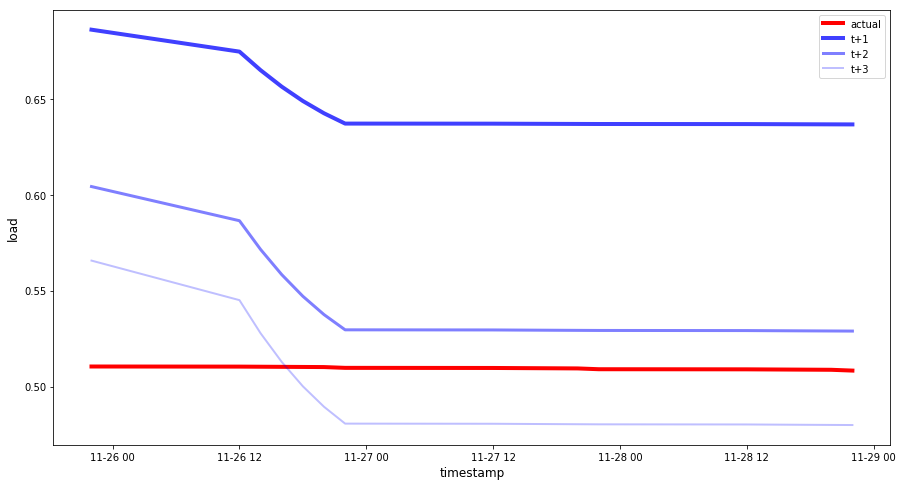

In [59]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [60]:
a = df.iloc[156:162  , :]
a

,OMEGA
Epoch_Time_of_Clock,
2017-11-28 12:00:00,0.50910438027500004576
2017-11-28 14:00:00,0.50904525936699995814
2017-11-28 16:00:00,0.50898615747599995629
2017-11-28 18:00:00,0.50892681859300004099
2017-11-28 20:00:00,0.50886720468199997391
2017-11-28 22:00:00,0.50880709484099995166


In [61]:
new_df = pd.DataFrame()

In [62]:
columns = [var_name] 

In [63]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [64]:
new_df = new_df.dropna( how = 'any')

In [65]:
new_df

,OMEGA
Epoch_Time_of_Clock,
2017-11-28 12:00:00,0.50910438027500004576
2017-11-28 14:00:00,0.50904525936699995814
2017-11-28 16:00:00,0.50898615747599995629
2017-11-28 18:00:00,0.50892681859300004099
2017-11-28 20:00:00,0.50886720468199997391
2017-11-28 22:00:00,0.50880709484099995166


In [66]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 29)

In [67]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [68]:
date

DatetimeIndex(['2017-11-29 12:00:00', '2017-11-29 14:00:00',
               '2017-11-29 16:00:00', '2017-11-29 18:00:00',
               '2017-11-29 20:00:00', '2017-11-29 22:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='2H')

In [69]:
new_df.index= date

In [70]:
new_df.columns

Index(['OMEGA'], dtype='object')

In [71]:
print(new_df)
print(new_df.columns)

                                     OMEGA
Epoch_Time_of_Clock                       
2017-11-29 12:00:00 0.50910438027500004576
2017-11-29 14:00:00 0.50904525936699995814
2017-11-29 16:00:00 0.50898615747599995629
2017-11-29 18:00:00 0.50892681859300004099
2017-11-29 20:00:00 0.50886720468199997391
2017-11-29 22:00:00 0.50880709484099995166
Index(['OMEGA'], dtype='object')


In [72]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                      OMEGA
Epoch_Time_of_Clock                        
2017-11-29 12:00:00 -2.94811737253914740720
2017-11-29 14:00:00 -2.94865849421604053759
2017-11-29 16:00:00 -2.94919944183418980543
2017-11-29 18:00:00 -2.94974255859203537966
2017-11-29 20:00:00 -2.95028819262537034263


In [73]:
print(new_new_df)
print(inputs['X'])

tensor                                    X                          \
feature                               OMEGA                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-29 22:00:00 -2.94811737253914740720 -2.94865849421604053759   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-29 22:00:00 -2.94919944183418980543 -2.94974255859203537966   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-

In [74]:
predictions = model.predict(inputs['X'])

In [75]:
predictions

array([[-1.780963 , -2.7662616, -3.2142093, -3.370727 , -3.3863864,
        -3.3406494]], dtype=float32)

In [76]:
print(predictions.shape)


(1, 6)


In [77]:
results = predictions[-1, :]

In [78]:
results

array([-1.780963 , -2.7662616, -3.2142093, -3.370727 , -3.3863864,
       -3.3406494], dtype=float32)

In [79]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,OMEGA
0,-1.78096294403076171875
1,-2.76626157760620117188
2,-3.21420931816101074219
3,-3.37072706222534179688
4,-3.38638639450073242188
5,-3.34064936637878417969


In [80]:
res_df.index = date
res_df

,OMEGA
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-1.78096294403076171875
2017-11-29 14:00:00,-2.76626157760620117188
2017-11-29 16:00:00,-3.21420931816101074219
2017-11-29 18:00:00,-3.37072706222534179688
2017-11-29 20:00:00,-3.38638639450073242188
2017-11-29 22:00:00,-3.34064936637878417969


In [81]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [82]:
# final generated ouput
res_df

,OMEGA
Epoch_Time_of_Clock,
2017-11-29 12:00:00,0.63662326335906982422
2017-11-29 14:00:00,0.52897328138351440430
2017-11-29 16:00:00,0.48003217577934265137
2017-11-29 18:00:00,0.46293163299560546875
2017-11-29 20:00:00,0.46122077107429504395
2017-11-29 22:00:00,0.46621781587600708008


In [84]:
res_df.to_csv('SA1OMEGA.csv')